# Modeling part. Spaceship Titanic competition.

This is the second notebook for the Spaceship Titanic project, where our focus is on developing the most effective pipeline for this problem. Our primary objective is to reach a minimum accuracy of 0.79 on the test set. We'll create and analyze new features, identifying the most important ones, and experiment with various preprocessing techniques. Additionally, we'll explore different models and select the one that delivers the highest accuracy.

## Results:
After thorough examination, **CatBoost** model has been chosen as the most effective for our problem. The final model's performance on the test set is almost 80% which means our goal of having at least 79% score is achieved.

The categorical columns (Departure planet, Destination planet, Deck, Side, CryoSleep) were important in predicting the target variable, with CryoSleep standing out—those in suspended animation had a higher chance of being transported to another dimension. Additionally, service-related features were influential, especially the RoomSpaVRDeck feature (sum of VRDeck, RoomService, and Spa), which proved significant. The CabinGroup feature also showed importance, stemming from insights during Exploratory Data Analysis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helper_functions
from sklearn.linear_model import LinearRegression
from scipy.stats import chi2_contingency
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (StandardScaler, 
                                   OneHotEncoder, 
                                   OrdinalEncoder, 
                                   FunctionTransformer)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import svm 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.impute import KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from category_encoders import TargetEncoder
import optuna
from sklearn.metrics import (accuracy_score, recall_score, 
                             precision_score, f1_score, confusion_matrix)
from sklearn.base import clone
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from imputers import *
import shap
import joblib

In [2]:
data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")
submission_data = pd.read_csv("data/sample_submission.csv")

## Baseline score:

We will use only the original columns, encode them and fit the Logistic Regression model with original parameters. 

In [3]:
data_baseline = data.copy()
data_baseline.drop(columns=["PassengerId", "Name", "Cabin"], inplace=True)

pd.set_option('future.no_silent_downcasting', True)
data_baseline.replace({True: 1, False: 0}, inplace=True)

X_baseline = data_baseline.drop(columns="Transported")
y_baseline = data_baseline.loc[:, "Transported"].astype(int)

**Encodings**:
* Numeric columns:
   * Services columns: log encoding + standard scaler
   * Age: standard scaler
* Categorical columns:
   * HomePlanet, Destination: OneHotEncoder

We will use mean and mode imputations.

In [4]:
log_transformer = FunctionTransformer(np.log1p, validate=False, 
                                      feature_names_out="one-to-one")
onehot = OneHotEncoder()
mode_imputer = SimpleImputer(strategy="most_frequent")
mean_imputer = SimpleImputer(strategy="mean")
std_scaler = StandardScaler()

services = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
log_std = Pipeline([
    ("imputer", mean_imputer),
    ('log', log_transformer),
    ('standardize', std_scaler)
])

std = Pipeline([
    ("imputer", mean_imputer),
    ("std", StandardScaler())
])

cat_col = ["HomePlanet", "Destination"]
one_hot_pipe = Pipeline([
    ("imputer", mode_imputer),
    ("one_hot", onehot)
])

preprocessor = ColumnTransformer(
    transformers=[
        ("std_age", std, ["Age"]),
        ("log_std", log_std, services),
        ("one_hot", one_hot_pipe, cat_col),
        ("simple_imputer", mode_imputer, ["CryoSleep", "VIP"])
    ])

In [5]:
train_X, val_X, train_y, val_y = train_test_split(X_baseline, y_baseline,
                                                  test_size=0.2, random_state=2, 
                                                  stratify=y_baseline)

In [6]:
baseline_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("algorithm", LogisticRegression(random_state=0))
])
helper_functions.get_scores(baseline_pipeline, train_X, train_y)

{'accuracy': 0.773224043715847,
 'recall': 0.7901199314677327,
 'precision': 0.7666943751731782,
 'f1': 0.7782309098579665}

In [7]:
helper_functions.get_scores(baseline_pipeline, val_X, val_y, fit=False)

{'accuracy': 0.7676825761932144,
 'recall': 0.7728310502283106,
 'precision': 0.7675736961451247,
 'f1': 0.770193401592719}

LogisticRegression model with the base parameters and original columns has given us 76% accuracy on the validation set. Let's create more features and try out different algorithms to see if we can get better results.

## Creating new features. Analysis of predictors

**Let's create the following features:**

1. Group Number: number of the group the person belongs to.
2. Deck of the ship
3. Side of the ship
4. CabinNumber - number of the cabin
5. CabinGroup - binned number of the cabin
5. Sum of money for all services
6. Sum of money for the following services: 'RoomService','Spa','VRDeck'
7. Sum of money for the following services: "ShoppingMall", "FoodCourt"
8. Indicator whether the person is a child(< 18 years)

**In addition, we will concatenate train and test data and compute the following features will be created:**
1. Number of people in a cabin that the person belongs to
2. Indicator whether a person in a group of more than 2 people or not

Concatenating is required as we will be able to get full information about each person.


**Imputation**

Our EDA gave us some hints on how we could impute missing values for some of the columns based on the associations between them. Therefore, we have come up with some imputation methods for different predictors columns:
* CryoSleep: if the sum of all services is equal to 0, then CryoSleep value will be 1. In other cases, it will be 0.
* HomePlanet: for passengers from A, B, C decks, the value will be Europa, for passengers from G deck, the value is Earth, for passengers from D deck, the value is Mars. For passengers who are travelling to PSO J318.5-22, the value will be Earth. In addition, passengers, who are from the same group or share the same last name, will get the same HomePlanet value.
* Service columns: if the CryoSleep value is 1, then 0 for each column. Imputation of other missing values will be discussed further.
* CabinNumber: fit linear regression based on group number column. After it, we will also create two additional features: 

For all the other columns, for now, simple imputation techniques will be used. In the further part of the project, we will experiment with some more difficult techniques.

In [8]:
data_new = data.copy()
test_data_new = test_data.copy()


for dataset in [data_new, test_data_new]:
    dataset[['Deck', 'CabinNumber', 'Side']] = (dataset["Cabin"]
                                                .str.split('/', expand=True))
    dataset["CabinNumber"] = dataset["CabinNumber"].astype(float)
    dataset.loc[:, "Group"] = dataset["PassengerId"].str[:4].astype(int)
    dataset['last_name'] = dataset["Name"].str.split(' ', expand=True)[1]
    dataset["child"] = dataset["Age"].apply(lambda x: 1 if x < 18 else 0)
    dataset["AllServices"] = dataset[services].sum(axis=1)
    dataset["RoomSpaVrDeck"] = dataset[["RoomService", "Spa", "VRDeck"]].sum(axis=1)
    dataset["MallFood"] = dataset[["ShoppingMall", "FoodCourt"]].sum(axis=1)

# add new services column to the list of services 
services.extend(["AllServices", "RoomSpaVrDeck", "MallFood"])

# for imputation, create copy of the new dataframe
data_imputed = data_new.copy()
# imputation of CabinNumber(needed to create CabinGroup and CabinCount columns)
lin_reg_imp = LinearRegressionImputer(target_col="CabinNumber", feature_col="Group")
data_imputed["CabinNumber"] = lin_reg_imp.fit_transform(data_imputed)
test_data_new["CabinNumber"] = lin_reg_imp.transform(test_data_new)

data_imputed.loc[:, "CabinGroup"] = pd.cut(data_imputed["CabinNumber"],
                                           bins=[0, 300, 650, 1150, 2000],
                                           include_lowest=True,
                                           labels=[1, 2, 3, 4])

test_data_new.loc[:, "CabinGroup"] = pd.cut(test_data_new["CabinNumber"],
                                           bins=[0, 300, 650, 1150, 2000],
                                           include_lowest=True,
                                           labels=[1, 2, 3, 4])

Concatenate the data and and create additional columns

In [9]:
combined_data = pd.concat([data_imputed, test_data_new])
combined_data.loc[:, "GroupCount"] = combined_data.groupby("Group").transform("size")
combined_data.loc[:, "MultipleGroup"] = (combined_data["GroupCount"]
                                         .apply(lambda x: 0 if x == 1 else 1))
combined_data.loc[:, "CabinCount"] = combined_data.groupby("CabinNumber").transform("size")


data_imputed[['MultipleGroup', 'CabinCount']] = (combined_data.loc[
    combined_data['PassengerId'].isin(data_imputed['PassengerId']), 
    ['MultipleGroup', 'CabinCount']])
test_data_new[['MultipleGroup', 'CabinCount']] = combined_data.loc[
    combined_data['PassengerId'].isin(test_data_new['PassengerId']), 
    ['MultipleGroup', 'CabinCount']]

Imputation of other columns:

In [10]:
# cryosleep
cryosleep_impute = CryoSleepImputer(services_column="AllServices")
data_imputed["CryoSleep"] = cryosleep_impute.fit_transform(data_imputed, "AllServices")

# homeplanet
planet_imputer = HomePlanetImputer()
data_imputed["HomePlanet"] = planet_imputer.fit_transform(data_imputed)

# services columns 
service_imp = ServiceImputer(services=services)
data_imputed[services] = service_imp.fit_transform(data_imputed)
for service in services:
    data_imputed.fillna({service: data_imputed[service].mean()}, inplace=True)

data_imputed.fillna({"Age": data_imputed["Age"].mean()}, inplace=True)

data_imputed.fillna({"VIP": data_imputed["VIP"].mode()[0]}, inplace=True)

one_hot_encoded = ["Deck", "Side", "HomePlanet", "Destination"]
data_imputed = pd.concat([data_imputed, 
                          pd.get_dummies(data_imputed[one_hot_encoded])], 
                         axis=1)
data_imputed.drop(columns=["last_name", "Name", 
                           "Side", "Deck", "Destination",
                           "Cabin", "PassengerId", "HomePlanet"],
                  inplace=True)

**Predictor analysis:**

Mutual information scores:

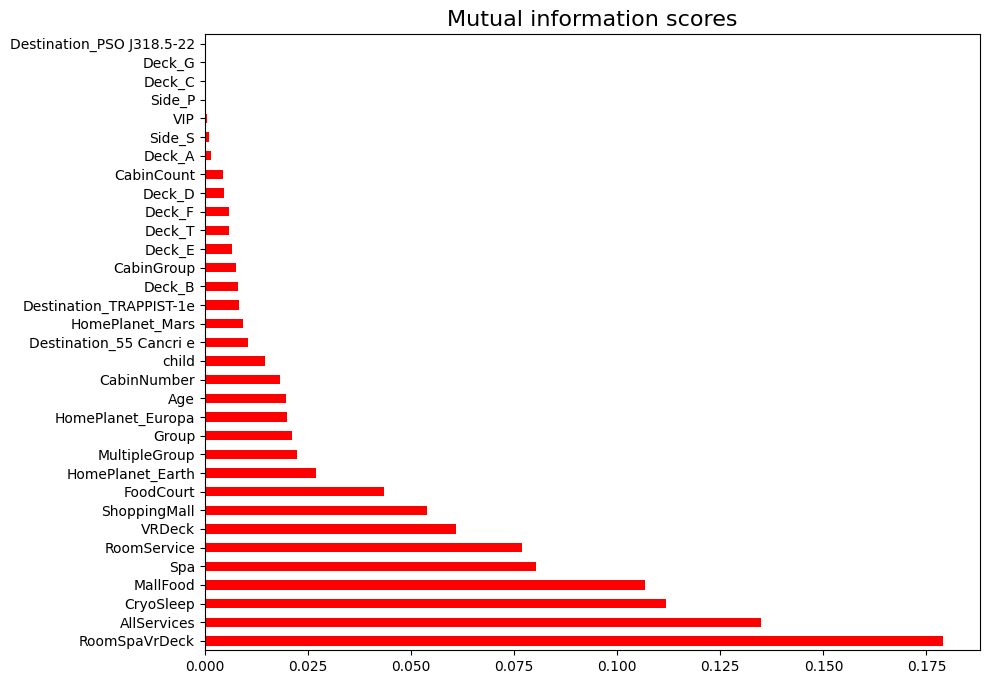

In [11]:
plt.figure(figsize=(10, 8))
mi_scores = helper_functions.make_mi_scores(data_imputed.drop(columns="Transported"), 
                                            data_imputed.loc[:, "Transported"],
                                            random_state=1)
mi_scores.plot(kind="barh", color="red")
plt.title("Mutual information scores", fontsize=16);

RoomSpaVrDeck stands out as a good predictor, as its mutual information score with the target variable is the highest. All of the services columns are among the columns with the highest mutual information scores. Also, CryoSleep column has high mutual information score.

Let's check correlation coefficients of features with target variables:

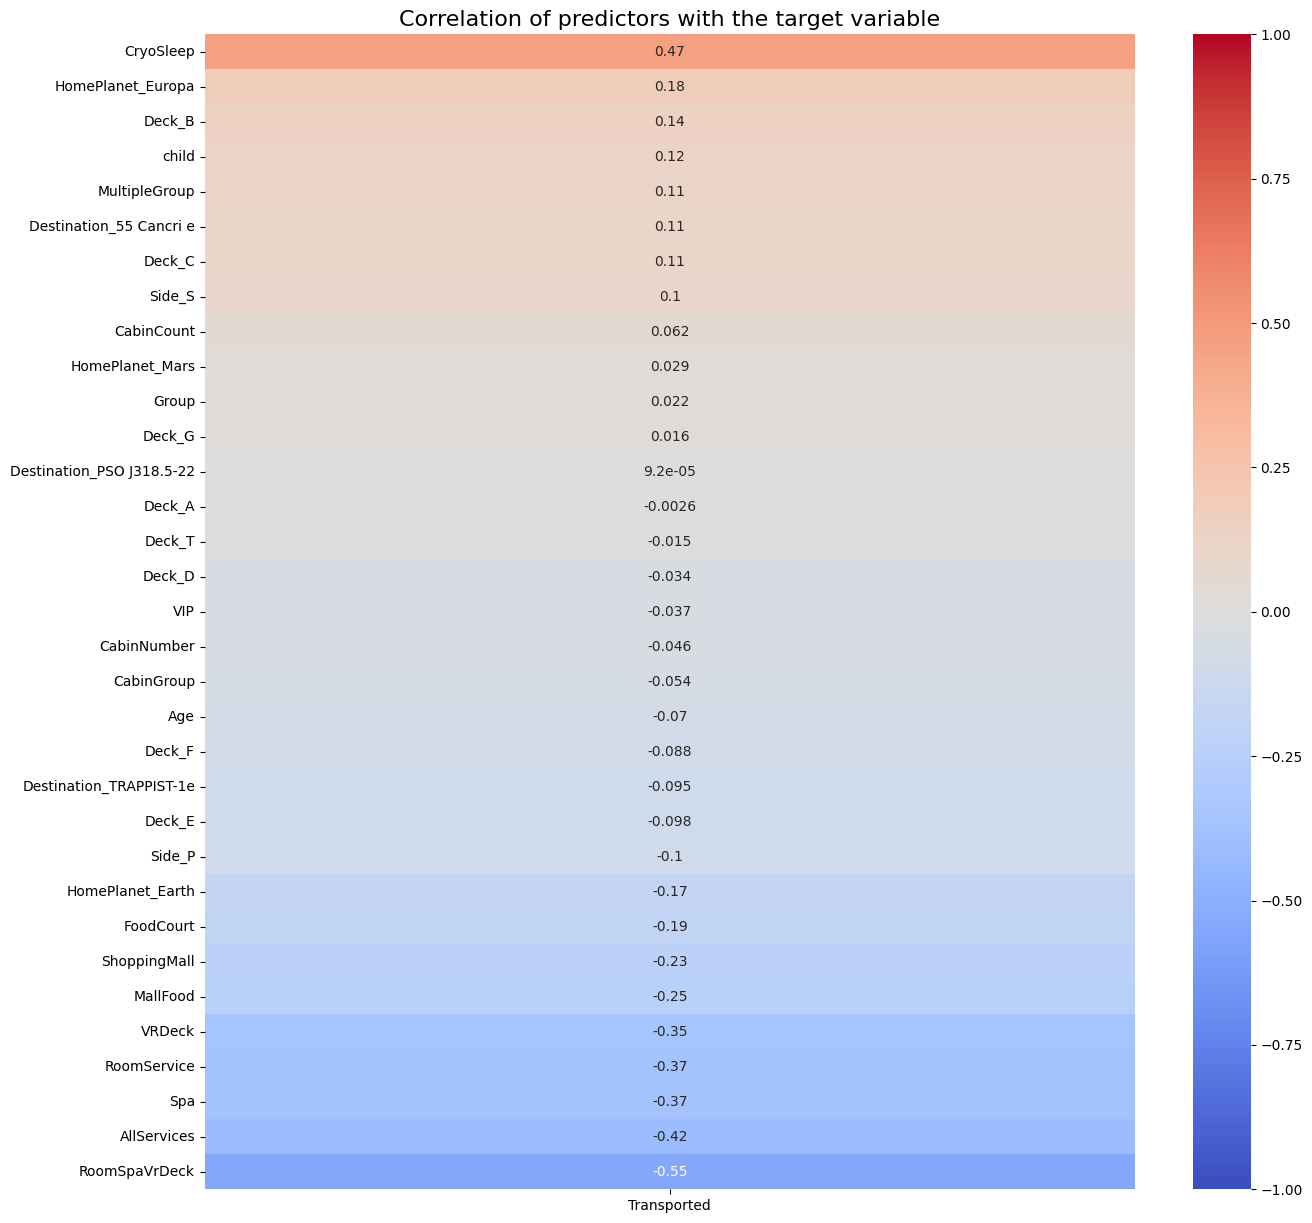

In [12]:
plt.figure(figsize=(15, 15))
heatmap = sns.heatmap(
    data_imputed.corr("spearman")[["Transported"]]
    .sort_values(by="Transported", ascending=False).drop("Transported"),
    vmin=-1,
    vmax=1,
    annot=True, 
    cmap="coolwarm"
)
heatmap.set_title("Correlation of predictors with the target variable",
                 fontsize=16);

We can point out Europa, Deck_B, child, groupcount, multiplegroup columns as they have some positive correlation with our target variables.

VIP column has no correlation with the target variable. Also, its mutual information score is tiny.

Let's look at the strongly correlated features:

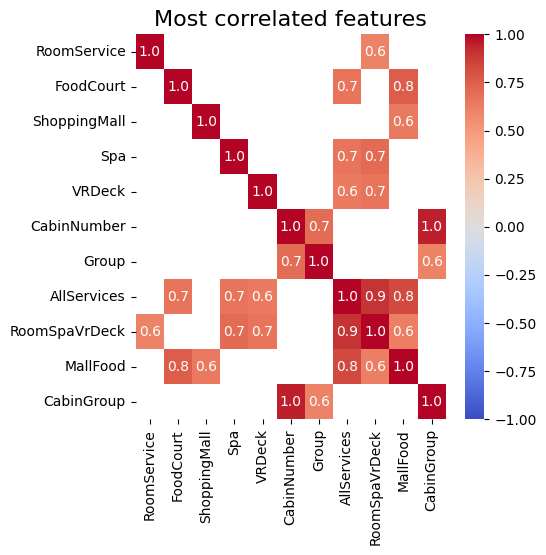

In [13]:
plt.figure(figsize=(5, 5))
corr_matrix = data_imputed.corr("spearman")

# extract columns with > 0.6 correlation
corr_matrix = (corr_matrix[corr_matrix > 0.6]
               .dropna(axis=1, thresh=2).dropna(axis=0, thresh=2))
heatmap = sns.heatmap(corr_matrix, vmin=-1, vmax=1, 
                      annot=True, cmap="coolwarm", fmt=".1f")
heatmap.set_title("Most correlated features", fontsize=16);

Some of the features unsuprisingly strongly correlated. Based on our analysis of the mutual information scores, correlations, we will train our models with the following features:
* HomePlanet
* CryoSleep
* Destination
* Age
* RoomService
* FoodCourt
* ShoppingMall
* Spa
* VRDeck
* Deck
* Side
* RoomSpaVrDeck
* child
* CabinGroup
* CabinCount
* MultipleGroup

For some of the imputation methods, we will keep "last_name", "Group", "CabinNumber" columns.

In [14]:
services.remove("AllServices")
services.remove("MallFood")

In [15]:
feature_set = ["HomePlanet", "CryoSleep", "Destination", "Age",
               "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck",
               "Deck", "Side", "RoomSpaVrDeck", 
               "last_name", "Group", "child", "CabinNumber"]
X = data_new.loc[:, feature_set]
y = data_new.loc[:, "Transported"]
X["CabinCount"] = data_imputed["CabinCount"]
X["MultipleGroup"] = data_imputed["MultipleGroup"]

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, 
                                                  stratify=y, random_state=2)

**Preprocessing pipeline for our model**
* OneHot encoding:
    * HomePlanet
    * Destination
    * Side
* Log transformer + standard scaler: 
    * Service columns
* Standard scaler:
    * Age
    * CabinCount
* LinearRegression
    * CabinNumber(needed to create CabinGroup feature)
    
Deck feature: We will try out the following encoding methods for this feature: one-hot encoding, target encoding and ordinal encoding.

Numeric missing values: For numeric columns, we will also try out the following imputation techniques: mean and knn.

In [16]:
# features needed for imputation of HomePlanet
planet_imp_features = ["HomePlanet", "Deck", "Destination", "last_name", "Group"]
cat_imputer = ColumnTransformer([
    ("homeplanet", HomePlanetImputer(), planet_imp_features),
    ("dest_side", mode_imputer, ["Destination", "Side"]), 
], remainder="drop")

one_hot_pipeline = Pipeline(steps=[
    ("imputer", cat_imputer),
    ("encoder", onehot)
])

In [17]:
service_pipeline = Pipeline(steps=[
    ('service_cond_imp', ServiceImputer(services=services+["CryoSleep"])),
    ('final_imputer', mean_imputer),
    ('log', log_transformer),
    ('standardize', std_scaler)
])

age_pipeline = Pipeline([
    ("imputer", mean_imputer),
    ("std", std_scaler)
])

cryosleep_imp = CryoSleepImputer(services_column="RoomSpaVrDeck")

cabin_group = CabinGroupTransformer(bins=[0, 300, 650, 1150, 2000],
                                    labels=[1, 2, 3, 4])
lin_reg_imputer = LinearRegressionImputer(target_col="CabinNumber",
                                         feature_col="Group")
cabin_group_pipe = Pipeline([
    ("lin_reg", lin_reg_imputer),
    ("cabin_group", cabin_group)
])

In [18]:
one_hot_pipe_features = ["HomePlanet", "Destination", 
                         "Deck", "Side", "last_name", "Group"]
cryosleep_col = ["CryoSleep", "RoomSpaVrDeck"]

preprocessing = ColumnTransformer([
    ("one_hot", one_hot_pipeline, one_hot_pipe_features),
    ("cryosleep", cryosleep_imp, cryosleep_col),
    ("services", service_pipeline, services+["CryoSleep"]),
    ("age", age_pipeline, ["Age"]),
    ("cabincount", StandardScaler(), ["CabinCount"]),
    ("cabingroup", cabin_group_pipe, ["Group", "CabinNumber"]),
    ("passthrough", "passthrough", ["MultipleGroup", "child"])
])

Now, we will implement different encodings for the Deck column.

In [19]:
ord_encoder = OrdinalEncoder()
target_encoder = TargetEncoder(cols="Deck")

# ordinal encoder
ord_pipe_deck = Pipeline(steps=[
    ("encode", ord_encoder),
    ("impute", mean_imputer),
])

# onehot encoder
onehot_pipe_deck = Pipeline(steps=[
    ("impute", mode_imputer),
    ("encode", onehot)
])

# target encoder
target_pipe_deck = Pipeline(steps=[
    ("encode", target_encoder)
])

deck_pipelines = [target_pipe_deck,
                  ord_pipe_deck,
                  onehot_pipe_deck]

We will try the following algorithms:
* LogisticRegression
* DecisionTree
* RandomForest
* Linear Support Vector Machine
* RBF support vector machine

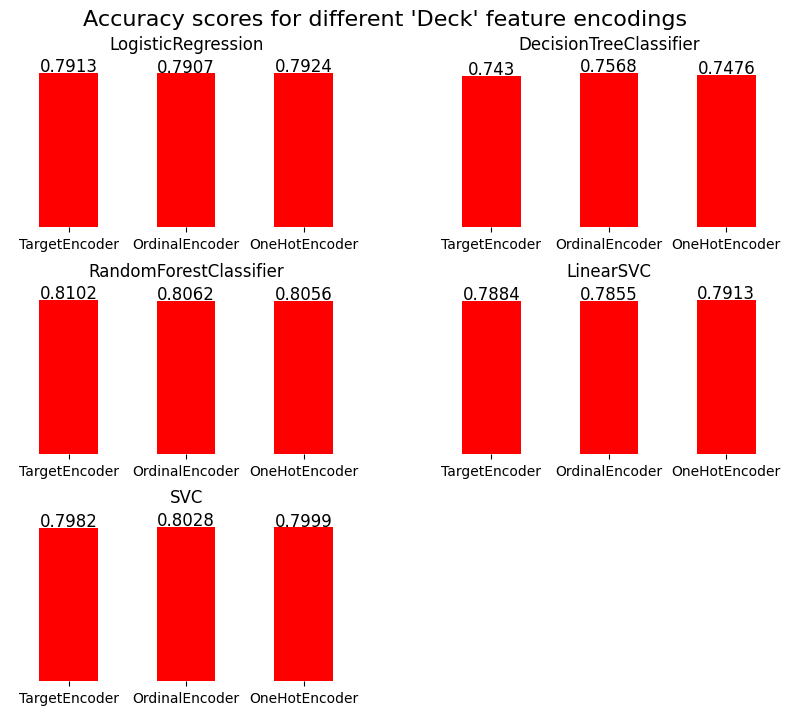

In [20]:
algorithms = [LogisticRegression(C=1, random_state=2),
             DecisionTreeClassifier(random_state=2),
             RandomForestClassifier(random_state=2),
             svm.LinearSVC(random_state=2),
             svm.SVC(random_state=2, kernel="rbf", C=1, gamma=0.1)]
                           
fig = plt.figure(figsize=(10, 8))
plt.subplots_adjust(hspace=0.4)
plt.suptitle("Accuracy scores for different 'Deck' feature encodings",
             fontsize=16, y=0.95)

for i, algorithm in enumerate(algorithms):
    ax = fig.add_subplot(3, 2, i+1)
    accuracy_res = pd.Series()
    # train each algorithm on all deck encodings
    for deck_pipe in deck_pipelines:
        preprocessing = ColumnTransformer([
            ("one_hot", one_hot_pipeline, one_hot_pipe_features),
            ("cryosleep", cryosleep_imp, cryosleep_col),
            ("services", service_pipeline, services+["CryoSleep"]),
            ("age", age_pipeline, ["Age"]),
            ("deck", deck_pipe, ["Deck"]),
            ("cabincount", StandardScaler(), ["CabinCount"]),
            ("cabingroup", cabin_group_pipe, ["Group", "CabinNumber"]),
            ("passthrough", "passthrough", ["MultipleGroup", "child"])
        ])
        model = Pipeline(steps=[
            ("preprocessing", preprocessing),
            ("algorithm", algorithm)])
        model.fit(train_X, train_y)
        label = str(deck_pipe.named_steps["encode"])
        label = label[:label.find("(")]
        
        val_res = pd.Series(helper_functions.get_scores(model, val_X, val_y, fit=False))
        accuracy_res[label] = val_res["accuracy"]
    accuracy_res.plot(ax=ax, kind="bar", color="red")
    title = str(algorithm)
    title = title[:title.find("(")]
    ax.set_title(title, y=1.05)
    helper_functions.customize_bar(axes=ax, round_to=4, position="v")

From the above plots, we see that the difference in scores is pretty small. Let's go with one-hot encoding for now.

**Try different encodings for numeric columns**

Mean encoding:

In [21]:
preprocessing_mean = ColumnTransformer([
    ("one_hot", one_hot_pipeline, one_hot_pipe_features),
    ("cryosleep", cryosleep_imp, cryosleep_col),
    ("services", service_pipeline, services+["CryoSleep"]),
    ("age", age_pipeline, ["Age"]),
    ("cabincount", StandardScaler(), ["CabinCount"]),
    ("deck", onehot_pipe_deck, ["Deck"]),
    ("cabingroup", cabin_group_pipe, ["Group", "CabinNumber"]),
    ("passthrough", "passthrough", ["MultipleGroup", "child"])
])

KNN encoding:

In [22]:
service_scaling = Pipeline([
    ('log', log_transformer),
    ('standardize', std_scaler)
])

numeric_transformer = ColumnTransformer([
    ("service_scaling", service_scaling, services),
    ("age_scaling", std_scaler, ["Age"])
])

numeric_knn = Pipeline([
    ("num_transformer", numeric_transformer),
    ("knn", KNNImputer())
])

preprocessing_KNN = ColumnTransformer([
    ("one_hot", one_hot_pipeline, one_hot_pipe_features),
    ("cryosleep", cryosleep_imp, cryosleep_col),
    ("numeric_transformer", numeric_knn, ["Age"] + services),
    ("deck", onehot_pipe_deck, ["Deck"]),
    ("cabincount", StandardScaler(), ["CabinCount"]),
    ("cabingroup", cabin_group_pipe, ["Group", "CabinNumber"]),
    ("passthrough", "passthrough", ["MultipleGroup", "child"])
])

In [23]:
preprocessors = {"KNN": preprocessing_KNN,
                 "Mean": preprocessing_mean}

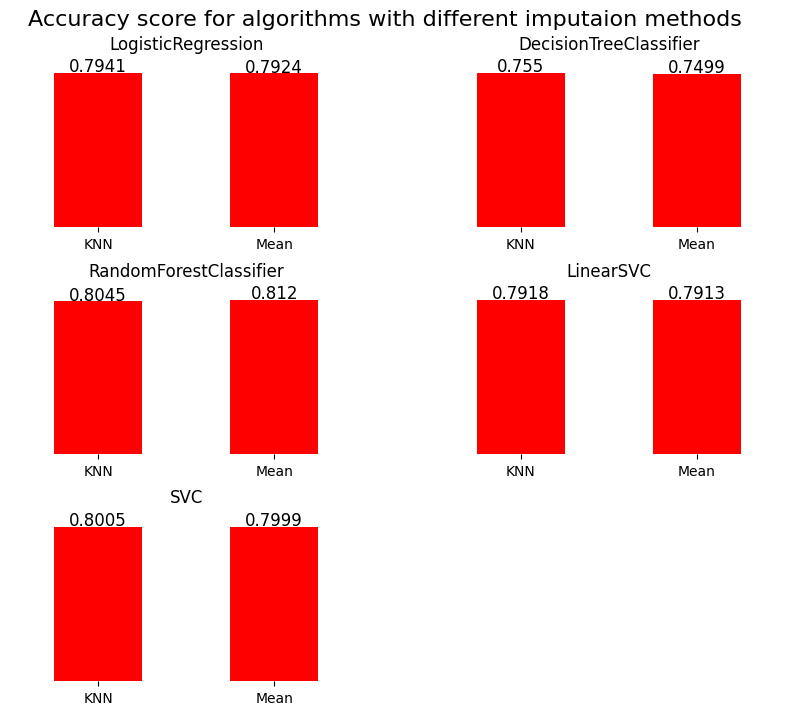

In [24]:
algorithms = [LogisticRegression(C=1, random_state=2),
             DecisionTreeClassifier(random_state=2),
             RandomForestClassifier(random_state=2),
             svm.LinearSVC(random_state=2),
             svm.SVC(random_state=2, kernel="rbf", C=1, gamma=0.1)]
                           
fig = plt.figure(figsize=(10, 8))
plt.subplots_adjust(hspace=0.4)
plt.suptitle("Accuracy score for algorithms with different imputaion methods",
             fontsize=16, y=0.95)

# train each algorithm and plot the scores 
for i, algorithm in enumerate(algorithms):
    ax = fig.add_subplot(3, 2, i+1)
    accuracy_res = pd.Series()
    for key, value in preprocessors.items():
        pipe = Pipeline(steps=[
            ("preprocessing", value),
            ("algorithm", algorithm)])
        pipe.fit(train_X, train_y)
        
        val_res = pd.Series(helper_functions.get_scores(pipe, val_X, val_y, fit=False))
        accuracy_res[key] = val_res["accuracy"]
    accuracy_res.plot(ax=ax, kind="bar", color="red")
    title = str(algorithm)
    title = title[:title.find("(")]
    ax.set_title(title, y=1.05)
    helper_functions.customize_bar(axes=ax, round_to=4, position="v")

Again all of the imputation methods give almost the same result. Therefore, we will go with the simplest one: mean imputation.

To compare algorithms, let's look at their confusion matrices:

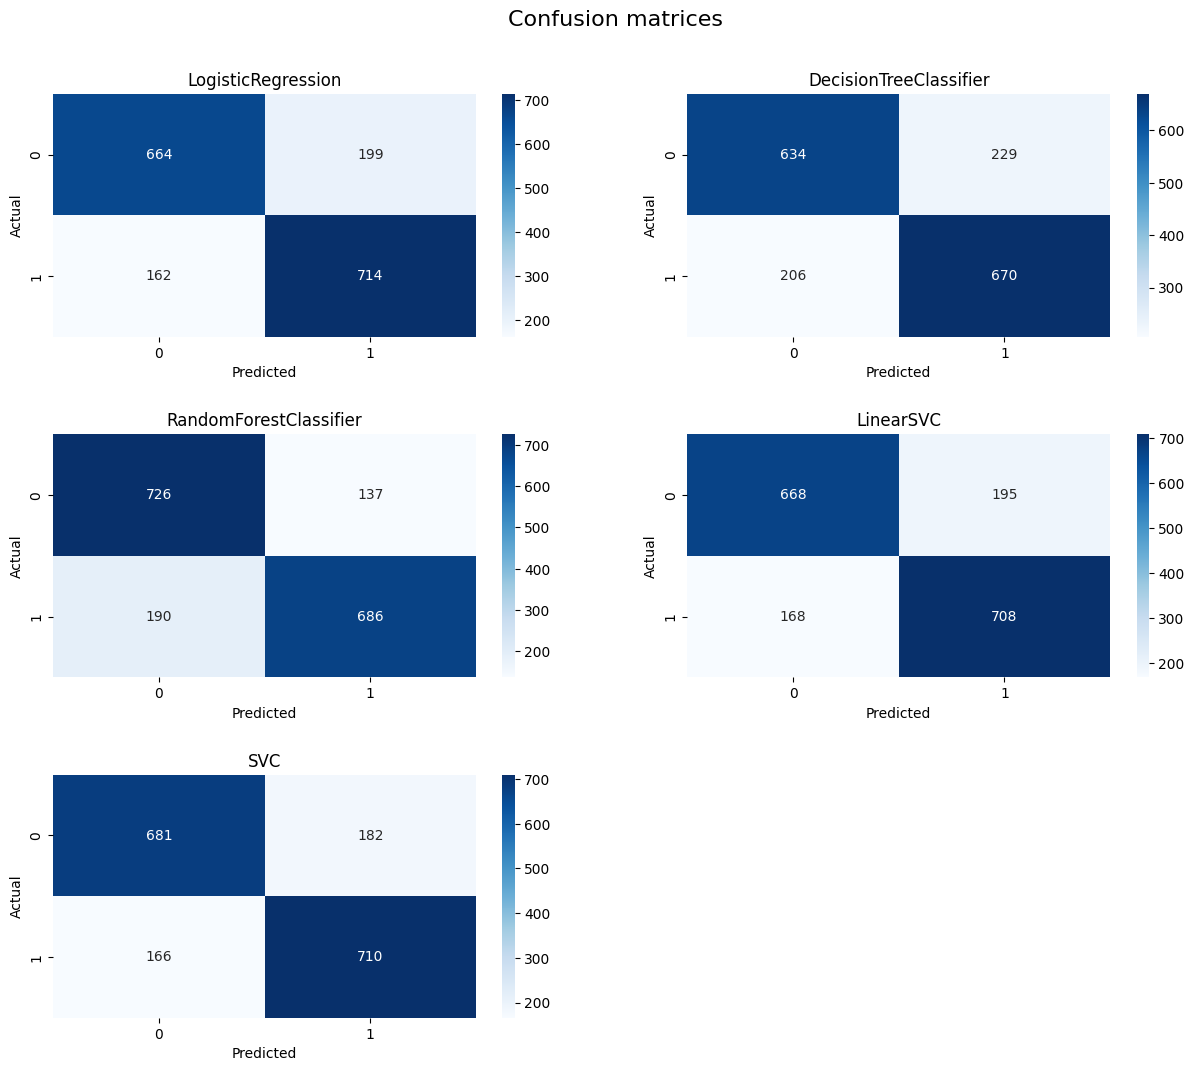

In [25]:
algorithms = [LogisticRegression(C=1, random_state=2),
             DecisionTreeClassifier(random_state=2),
             RandomForestClassifier(random_state=2),
             svm.LinearSVC(random_state=2),
             svm.SVC(random_state=2, kernel="rbf", C=1, gamma=0.1)]
figsize = (15, 12)
fig = plt.figure(figsize=figsize)
plt.subplots_adjust(hspace=0.4)
plt.suptitle("Confusion matrices", fontsize=16, y=0.95)

# train each algorithm and plot the scores
predictions = {}
for i, algorithm in enumerate(algorithms):
    ax = fig.add_subplot(3, 2, i+1)
    preprocessing = ColumnTransformer([
        ("one_hot", one_hot_pipeline, one_hot_pipe_features),
        ("cryosleep", cryosleep_imp, cryosleep_col),
        ("services", service_pipeline, services+["CryoSleep"]),
        ("age", age_pipeline, ["Age"]),
        ("cabincount", StandardScaler(), ["CabinCount"]),
        ("deck", onehot_pipe_deck, ["Deck"]),
        ("cabingroup", cabin_group_pipe, ["Group", "CabinNumber"]),
        ("passthrough", "passthrough", ["MultipleGroup", "child"])
    ])
    
    pipe = Pipeline(steps=[
        ("preprocessing", preprocessing),
        ("algorithm", algorithm)])
    pipe.fit(train_X, train_y)

    preds = pipe.predict(val_X)
    title = str(algorithm)[:str(algorithm).find("(")]
    cm = confusion_matrix(val_y, preds)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(title)

All of the algorithms show similar results. I would highlight Decision Tree and Random Forest as they give these results with their base parameters. By tuning the parameters, we may achieve better outcomes.

**Hyperparameter tuning**

Now, let's tune parameters for Random Forest algorithm. We will use optuna.

In [26]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [27]:
def forest_objective(trial):
    forest_params = dict(
        n_estimators=trial.suggest_int("n_estimators", 50, 200),
        max_features=trial.suggest_categorical("max_features", 
                                               [0.5, 0.6, 0.7, 0.8, 
                                                1.0, 'sqrt', 'log2']),
        max_depth=trial.suggest_int("max_depth", 5, 10),
        min_samples_split=trial.suggest_int("min_samples_split", 10, 70),
        criterion=trial.suggest_categorical("criterion", ["gini", "entropy"]),
        random_state=2
    )
    
    preprocessing = ColumnTransformer([
        ("one_hot", one_hot_pipeline, one_hot_pipe_features),
        ("cryosleep", cryosleep_imp, cryosleep_col),
        ("services", service_pipeline, services+["CryoSleep"]),
        ("age", age_pipeline, ["Age"]),
        ("cabincount", StandardScaler(), ["CabinCount"]),
        ("deck", onehot_pipe_deck, ["Deck"]),
        ("cabingroup", cabin_group_pipe, ["Group", "CabinNumber"]),
        ("passthrough", "passthrough", ["MultipleGroup", "child"])
    ])
    
    model = RandomForestClassifier(**forest_params)
    pipeline = Pipeline(steps=[
        ("preprocessing", preprocessing),
        ("modelling", model)
    ]) 
    cv_score = cross_val_score(pipeline, X, y, n_jobs=4, cv=3) 
    
    return cv_score.mean()

In [28]:
sampler = optuna.samplers.TPESampler(seed=0)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(forest_objective, n_trials=100, n_jobs=4)
forest_params = study.best_params
best_results = study.best_value
forest_params, best_results

({'n_estimators': 149,
  'max_features': 'log2',
  'max_depth': 9,
  'min_samples_split': 33,
  'criterion': 'entropy'},
 0.7996101723946122)

This is the results and parameters of our best Random Forest model. Almost 80% of mean accuracy on cross-validation means that this model has a good chance to achieve 79% accuracy on test data. However, let's try to get more. 

We will train gradient boosting algorithms:
* XGBoost 
* CatBoost

In [29]:
xgboost = XGBClassifier(random_state=0, n_estimators=2000,
                        early_stopping_rounds=50)
train_X_tf = preprocessing.fit_transform(train_X)
val_X_tf = preprocessing.transform(val_X)
xgboost.fit(
        train_X_tf,
        train_y,
        eval_set=[(train_X_tf, train_y), (val_X_tf, val_y)],
        verbose=0,
    )
helper_functions.get_scores(xgboost, val_X_tf, val_y, fit=False)

{'accuracy': 0.8073605520414031,
 'recall': 0.8264840182648402,
 'precision': 0.7982359426681367,
 'f1': 0.8121144139091419}

XGBoost algorithm with base parameters gives us more than 80% of accuracy on validation set. This is pretty promissing. 

Let's look into CatBoost algorithm. CatBoost algorithm nicely works with the dataset with a lot of categorical features. The preprocessing step is easier here as we don't need to use encoding. Therefore, we simplify the preprocessing pipeline for this model:

In [30]:
const_imputer = SimpleImputer(strategy="constant", fill_value="unknown")
cat_features = ["HomePlanet", "Destination", "Deck", "Side"]

cat_imputer = ColumnTransformer([
    ("homeplanet", HomePlanetImputer(), planet_imp_features),
    ("dest_side", const_imputer, ["Destination", "Side", "Deck"]), 
], remainder="drop")


pass_col = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck",
           "MultipleGroup", "child", "CabinCount", "RoomSpaVrDeck"]
cat_imp_features = cat_features + ["last_name", "Group"]
cb_preprocessor = ColumnTransformer([
    ("cat_col", cat_imputer, cat_imp_features),
    ("cryosleep", cryosleep_imp, cryosleep_col),
    ("cabingroup", cabin_group_pipe, ["CabinNumber", "Group"]),
    ("passthrough", "passthrough", pass_col)
])

cat_train_X = cb_preprocessor.fit_transform(train_X)
cat_val_X = cb_preprocessor.transform(val_X)

In [31]:
cat_boost = CatBoostClassifier(cat_features=[0, 1, 2, 3, 4], 
                               random_state=0, verbose=0,
                               early_stopping_rounds=50, iterations=2000
                              )
cat_boost.fit(cat_train_X, train_y, eval_set=(cat_val_X, val_y))
helper_functions.get_scores(cat_boost, cat_val_X, val_y, fit=False)

{'accuracy': 0.8142610695802185,
 'recall': 0.8230593607305936,
 'precision': 0.8110236220472441,
 'f1': 0.8169971671388102}

CatBoost algorithm with base parameters achieved around 1% better accuracy than XGBoost.

As always, we will go for more. Let's try to tune hyperparameters for CatBoost algorithm.

In [32]:
def catboost_objective(trial):
    cat_params = dict(
        depth=trial.suggest_int("depth", 1, 10),
        learning_rate=trial.suggest_float("learning_rate", 0.0001, 0.1, log=True),
        random_strength=trial.suggest_float("random_strength", 0, 5),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 2, 10, log=True),
        subsample=trial.suggest_float("subsample", 0.5, 1),
        colsample_bylevel=trial.suggest_float('colsample_bylevel', 0.5, 1),
        iterations=2000,
        random_state=0,
        early_stopping_rounds=20
    )
    model = CatBoostClassifier(cat_features=[0, 1, 2, 3, 4], verbose=0,
                               **cat_params)


    model.fit(cat_train_X, train_y, eval_set=(cat_val_X, val_y), verbose=0)
    preds = model.predict(cat_val_X)
    return accuracy_score(val_y, preds)

In [33]:
sampler = optuna.samplers.TPESampler(seed=0)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(catboost_objective, n_trials=200, n_jobs=2)
cat_params = study.best_params
best_results = study.best_value
cat_params, best_results

({'depth': 8,
  'learning_rate': 0.0026049562913886314,
  'random_strength': 1.940870114365934,
  'l2_leaf_reg': 4.442518753091212,
  'subsample': 0.6843469085726769,
  'colsample_bylevel': 0.8196209464350845},
 0.8177113283496262)

We have a model with 82% accuracy on the validation set. Our next objective is to train model again to get the number of iterations needed for this model. In addition, we will use shap to look into feature importances.

In [34]:
cat_boost = CatBoostClassifier(**cat_params, iterations=2000, 
                               early_stopping_rounds=20, verbose=0)
cat_boost.fit(cat_train_X, train_y, cat_features=[0, 1, 2, 3, 4],
              eval_set=(cat_val_X, val_y));

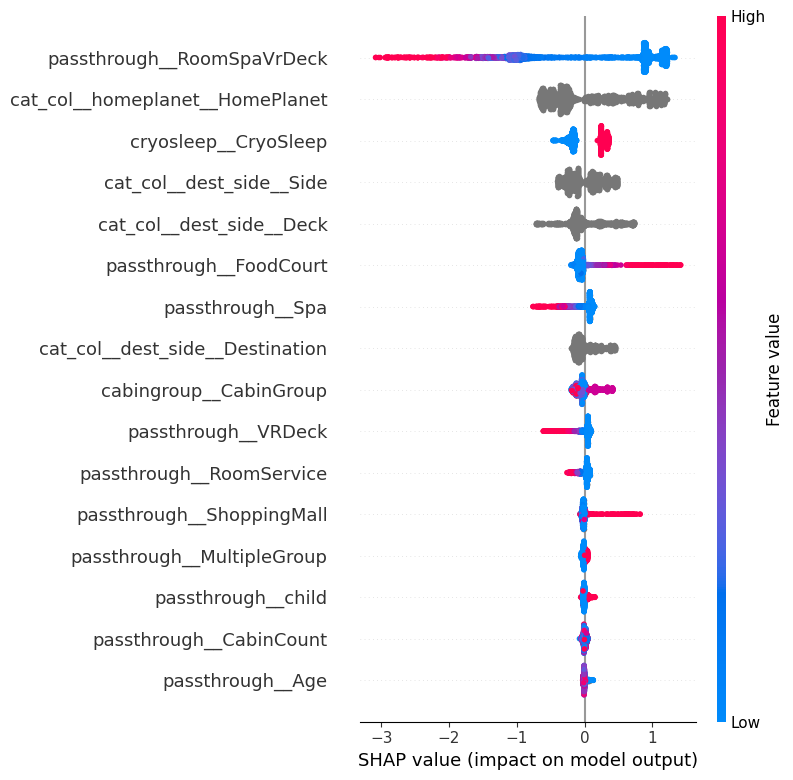

In [35]:
explainer = shap.Explainer(cat_boost)
shap_values = explainer(cat_val_X)
shap.summary_plot(shap_values, cat_val_X,
                  feature_names=cb_preprocessor.get_feature_names_out())  

All of the categorical features show decent importance in our model. As it was analysed in EDA, services column prove to be important. It is important to point out created feature RoomSpaVrDeck, which also shows high importance;

### Retraining the model on the full dataset

In [36]:
cat_boost = CatBoostClassifier(**cat_params, iterations=cat_boost.best_iteration_,
                               cat_features=[0, 1, 2, 3, 4], verbose=0)
cb_preprocessor = ColumnTransformer([
    ("cat_col", cat_imputer, cat_imp_features),
    ("cryosleep", cryosleep_imp, cryosleep_col),
    ("cabingroup", cabin_group_pipe, ["CabinNumber", "Group"]),
    ("passthrough", "passthrough", pass_col)
])
final_pipe = Pipeline([
    ("preprocessor", cb_preprocessor),
    ("catboost", cat_boost)
])

final_pipe.fit(X, y)
helper_functions.get_scores(final_pipe, X, y, fit=False)

{'accuracy': 0.8190498101921085,
 'recall': 0.8430790315212425,
 'precision': 0.8064234214551016,
 'f1': 0.8243439419318817}

## Submitting results to the Kaggle competition

Add new columns to the test set

In [37]:
test_data[['Deck', 'CabinNumber', 'Side']] = (test_data["Cabin"]
                                              .str.split('/', expand=True))
test_data["CabinNumber"] = test_data["CabinNumber"].astype(float)
test_data.loc[:, "Group"] = test_data["PassengerId"].str[:4].astype(int)
test_data['last_name'] = test_data["Name"].str.split(' ', expand=True)[1]
test_data["child"] = test_data["Age"].apply(lambda x: 1 if x < 18 else 0)
test_data["RoomSpaVrDeck"] = test_data[["RoomService", "Spa", "VRDeck"]].sum(axis=1)

test_data["MultipleGroup"] = test_data_new["MultipleGroup"]
test_data["CabinCount"] = test_data_new["CabinCount"]

In [38]:
predictions = final_pipe.predict(test_data)
submission_data["Transported"] = predictions
submission_data.to_csv("final_submissions.csv", index=False)

On the final test set, our model has achieved 0.79985 accuracy score. Our goal has been achieved.

Load the pipeline for the future deployment

In [39]:
joblib.dump(final_pipe, '../deployment/pipeline_with_catboost.pkl')

['../deployment/pipeline_with_catboost.pkl']

### Testing the deployed model:

Run the cell below, to post the prediction for the model and get the its response:

In [41]:
%run ../deployment/test.py

Enter the ID of the passenger in the following format:
(GroupNumber)_(ID): 0013_01
Enter first and last name of the passenger: Nelly Carsoning
Enter the value of HomePlanet(Europa/Earth/Mars): Earth
Enter the value of CryoSleep(True/False): True
Enter the value of Destination(TRAPPIST-1e/PSO J318.5-22/55 Cancri e): TRAPPIST-1e
Enter the value of VIP(True/False): False
Enter the value of Deck(B/F/A/G/E/D/C/T): G
Enter the value of Side(P/S): S
Enter the value of Age: 27
Enter the value of RoomService: 0
Enter the value of FoodCourt: 0
Enter the value of ShoppingMall: 0
Enter the value of Spa: 0
Enter the value of VRDeck: 0
Enter the value of CabinCount: 21
Enter the value of CabinNumber: 3
Enter the value of MultipleGroup: 0
{'probability': 0.5276526670361253}


Run the cell below to test the model's response times:

In [43]:
%run ../deployment/app_test.py

100%|█████████████████████████████████████████| 500/500 [01:23<00:00,  6.01it/s]


Response time in ms:
Median: 154.5
95th precentile: 204.04999999999995
Max: 747


# Conclusion
After thorough examination, **CatBoost** model has been chosen as the most effective for our problem. The final model's performance on the test set is almost 80% which means our goal of having at least 79% score is achieved.

## Key findings:
**Feature importance**: All the categorical columns(Departure planet, Destination planet, Deck, Side, CryoSleep) has proven to be important in predicting target variable. CryoSleep variable stands out the most. People, who have been put into suspended animation, had higher chances of being transformed to another dimenstion. In addition, services columns had a lot of influence in the model prediction. The created feature RoomSpaVRDeck(Sum of VRDeck, RoomService, and Spa) proved to be very important. Also, it is important to point out CabinGroup feature, which also had some feature importance. It was created after an interesting finding in the Exploratory Data Analysis.

**Model**: Our final model is CatBoost, which achieved almost 80% accuracy. Along with delivering the highest performance, CatBoost required the least complex preprocessing, as it handles categorical features without the need for encoding. These advantages make CatBoost the best model for our problem.

## Suggestion on improving the analysis:
* Incorporate the creation of the MultipleGroup and CabinCount features into our pipeline. These features were generated after merging the datasets to capture complete information about all passengers on the ship. We could create dictionaries to store the number of people in each cabin and the number of individuals in each group. This approach would allow us to utilize these dictionaries to generate the features, eliminating the need to input them manually when testing the deployed model.
* Experiment with the VotingClassifier. We could also explore the possibility of combining different algorithms into a single model and analyze the results.
* Utilize an AutoML tool. We could apply AutoML to address this problem and evaluate the scores it produces.